In [1]:
import sys
sys.path.append("..")

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import torch
from IPython.display import display, update_display
from PIL import Image
from models.dalle.dalle import MinDalle, get_tokenizer, prepare_tokens

In [25]:
torch.manual_seed(0)
torch.set_grad_enabled(False)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.allow_tf32 = True

is_mega = False
device = "cuda:3"

root_dir='../pretrained'
model = MinDalle(is_mega=is_mega, root_dir=root_dir, device=device)
tokenizer = get_tokenizer(os.path.join(root_dir, f"dalle_{'mega' if is_mega else 'mini'}"))


def predict(text, seamless, grid_size, temperature, supercondition_factor, top_k):
    tokens = prepare_tokens(tokenizer, text, device)
    images = model(
        text_tokens=tokens,
        grid_size=grid_size,
        is_seamless=seamless,
        temperature=temperature,
        top_k=int(top_k),
        supercondition_factor=float(supercondition_factor)
    )

    for i, image in enumerate(images):
         yield Image.fromarray(image.numpy())

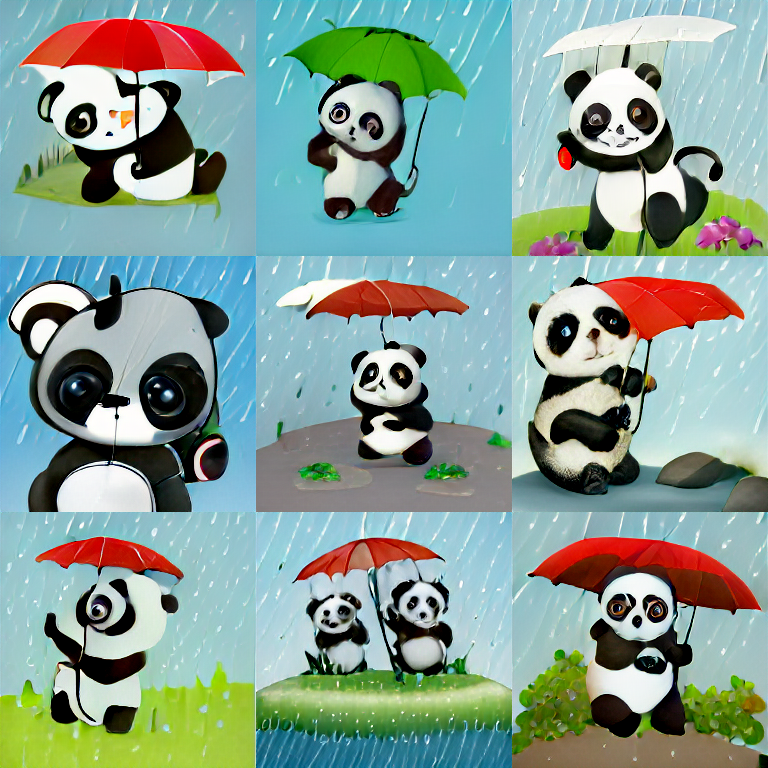

In [15]:
images = predict(
    text="an illustration of a baby panda with headphones holding an umbrella in the rain",
    seamless=False,
    grid_size=3,
    temperature=1,
    supercondition_factor=16,
    top_k=128,
)
next(images).show()

## Profile for predict

In [16]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], use_cuda=True) as prof:
    with record_function("predict"):
        list(
            predict(
                text="an illustration of a baby panda with headphones holding an umbrella in the rain",
                seamless=False,
                grid_size=3,
                temperature=1,
                supercondition_factor=16,
                top_k=128,
            )
        )

## analyze execution time
1. ops are not grouped under "record_function" name
2. it's not intuitive to tell what are the ops, where they are used
3. it would be nice to show the ops in a tree-like view, breaking down by user's functions

In [17]:
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::linear         1.36%     598.954ms        35.78%       15.796s     141.778us       0.000us         0.00%      37.748ms       0.339us        111416  
                                                predict         0.03%      12.999ms        99.99%       44.145s       44.145s       0.000us         0.00%      32.136ms      32.136ms             1  
         

## Export to view tracing in Chrome
1. the trace file is larger than 1 GB. Chrome doesn't support large tracing file
2. Is there a way to tune profiler args to reduce the size? e.g. add some filter to make it more coarse grained

In [18]:
prof.export_chrome_trace("trace.json")

## analyze memory consumption
1. aten::empty takes 72.65 Gb. I guess it's bit as my V100 only has 32GB. it's confusing to me. Can we use GB?
2. what's aten::empty? why it takes so much memory? I though most mem should be allocated to transformer and dense layers
3. why there is negative mem usage? e.g. "-1.23 Gb"

In [26]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:
    with record_function("predict"):
        list(
            predict(
                text="an illustration of a baby panda with headphones holding an umbrella in the rain",
                seamless=False,
                grid_size=3,
                temperature=1,
                supercondition_factor=16,
                top_k=128,
            )
        )

In [27]:
print(prof.key_averages().table(sort_by="cuda_memory_usage", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         4.94%        1.173s         4.94%        1.173s      14.503us       0.000us         0.00%       0.000us       0.000us     514.81 Kb     514.81 Kb      72.65 Gb      72.65 G

## Examining stack traces
1. I don't understand the "Source Location" column. Can we provide a filter that only shows the paths for users' code?
2. can we show the stack trace in a tree like view?

In [19]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], with_stack=True) as prof:
    with record_function("predict"):
        list(
            predict(
                text="an illustration of a baby panda with headphones holding an umbrella in the rain",
                seamless=False,
                grid_size=3,
                temperature=1,
                supercondition_factor=16,
                top_k=128,
            )
        )

In [20]:
print(prof.key_averages(group_by_stack_n=5).table(sort_by="self_cuda_time_total", row_limit=2))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -----------------------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  Source Location                                                          
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -----------------------------------------------------------------------  
                                        Memset (Device)         0.00%       0.000us         0.00%       0.000us       0.000us      19.769ms        60.85%      19.769ms       1.509us     

## Visualizing data as a flamegraph
1. generate modeling/profiling/perf_viz.svg following https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html#visualizing-data-as-a-flamegraph
2. it's hard to read the flamegraph. Anyway to make it cleaner? e.g. only show user code related ops?

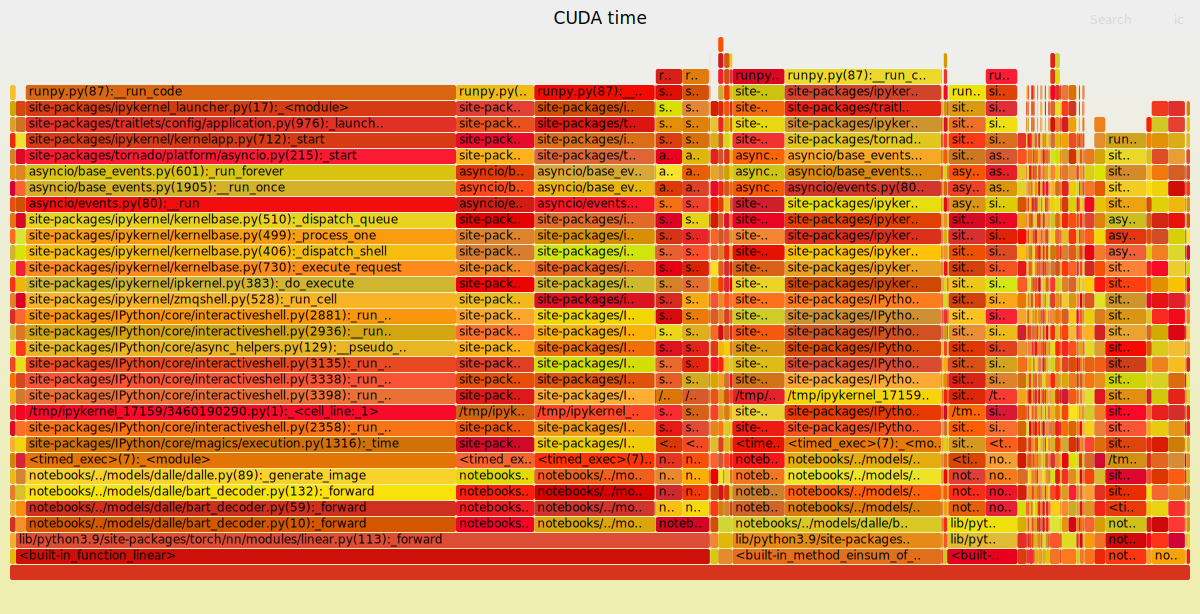

In [36]:
from IPython.display import SVG, display


path="../profiling/perf_viz.svg"
display(SVG(path))